# 데이터 전처리 성능 비교

## data1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor


def data1_prepro(df1=None, train=False, onehot=True):
    '''
    data1 전처리 함수.

    args:
        train : 학습용으로 전처리할것인지
        onehot : 원핫인코딩 할것인지 타겟인코딩 할것인지 (False=타겟인코딩)
    
    returns:
        X_train, X_test, y_train, y_test : train=True인경우
        X : train=False인 경우
    '''
    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')
    te = TargetEncoder(target_type='continuous')
    te.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')

    # 컬럼 변환기2 : Sex te, 나머지 표준화
    data1_ct_te = make_column_transformer(
        (te, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_te.set_output(transform='pandas')

    if 'Rings' in df1:
        X = df1.drop(columns='Rings')   
        y = df1.Rings
    else:
        X = df1

    if train:
        # test비율 20%로
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
        if onehot:
            X_train = data1_ct_ohe.fit_transform(X_train)
            X_test = data1_ct_ohe.transform(X_test)
        else:
            X_train = data1_ct_te.fit_transform(X_train, y_train)
            X_test = data1_ct_te.transform(X_test)
        return X_train, X_test, y_train, y_test
    else:
        return X
    

X_train, X_test, y_train, y_test = data1_prepro(train=True)
X_train_te, X_test_te, y_train_te, y_test_te = data1_prepro(train=True, onehot=False)

model = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model2 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

model2.fit(X_train_te, y_train_te,
          eval_set=[(X_test_te, y_test_te)],
          verbose=False)
''

''

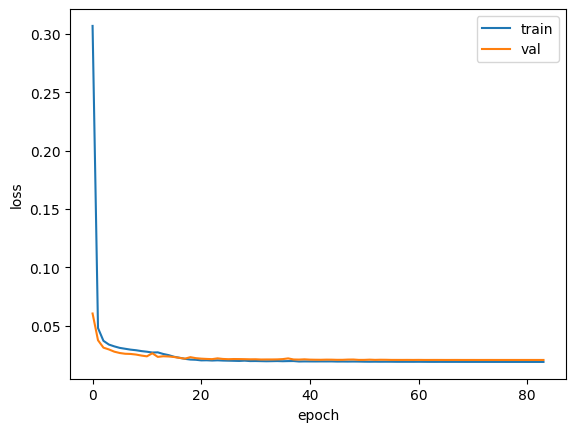

In [18]:
# AE로 차원축소
from tensorflow  import keras
import tensorflow as tf
import time


def AE_feature_extraction(X):
    """
    오토인코더로 차원축소 7 => 4
    학습후에 인코더만 반환
    """
    # 7 => 4
    encoder = keras.models.Sequential([
        keras.layers.Dense(4, activation='relu')
        ]
    )
    # 4 => 7
    decoder = keras.models.Sequential([
        keras.layers.Dense(7, activation=None)
        ]
    )
    # 컴파일 : loss = mse, opt = adam
    AutoEncoder = keras.Sequential([encoder, decoder])
    AutoEncoder.compile(optimizer=keras.optimizers.Adam(0.01),
                        loss='mse')
    
    # 콜백 정의
    # reduce_lr : 학습이 잘 안되면(6 epochs) 학습률 감소
    # e_stop : 특정epoch이상 차도 없으면(12 epochs) 중단
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
    e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=12,
                                              restore_best_weights=True)
    # 학습
    hist = AutoEncoder.fit(X, X,
                           batch_size=32,
                           validation_split=.25,
                           epochs=200,
                           callbacks=[e_stop, reduce_lr],
                           verbose=0)
    
    # 오토인코더 train, val의 epoch별 loss확인
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return encoder

encoder = AE_feature_extraction(X_train.iloc[:,3:])

In [19]:
X_train2 = np.hstack((X_train.iloc[:,:3], encoder.predict(X_train.iloc[:,3:], verbose=0)))
X_test2 = np.hstack((X_test.iloc[:,:3], encoder.predict(X_test.iloc[:,3:], verbose=0)))

model3 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model3.fit(X_train2, y_train,
           eval_set=[(X_test2, y_test)],
           verbose=False)
''

''

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_train3 = pca.fit_transform(X_train.iloc[:,3:])
X_test3 = pca.transform(X_test.iloc[:,3:])

X_train3 = np.hstack((X_train.iloc[:,:3], X_train3))
X_test3 = np.hstack((X_test.iloc[:,:3], X_test3))

model4 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model4.fit(X_train3, y_train,
           eval_set=[(X_test3, y_test)],
           verbose=False)
''

''

In [21]:
# 혹시 모르니 skewness 조정된 버전도 실험
from scipy.stats import boxcox
from scipy.special import boxcox1p

def data1_prepro_noskew(df1=None):

    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # boxcox로 Sex, Ring제외 skewness 전부 조정
    temp = df1[num_cols].apply(lambda x: x+0.001).apply(lambda x: boxcox(x)[0])
    X = pd.concat([df1[cat_cols], temp], axis=1)
    y = df1.Rings

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')
    
    # test비율 20%로
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=40)
    
    X_train = data1_ct_ohe.fit_transform(X_train)
    X_test = data1_ct_ohe.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train4, X_test4, y_train4, y_test4 = data1_prepro_noskew()

model5 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model5.fit(X_train4, y_train4,
           eval_set=[(X_test4, y_test4)],
           verbose=False)
''

''

In [22]:
def cv(model, X_train, X_test, y_train, y_test):
    rmse =cross_val_score(model, X_train, y_train,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          fit_params={'eval_set':[(X_test, y_test)],
                                      'verbose':False,})

    rmse = np.sqrt(np.abs(rmse))
    return rmse

ohe_rmse = cv(model, X_train, X_test, y_train, y_test)
ohe_noskew_rmse = cv(model5, X_train4, X_test4, y_train4, y_test4)
te_rmse = cv(model2, X_train_te, X_test_te, y_train_te, y_test_te)
ae_rmse = cv(model3, X_train2, X_test2, y_train, y_test)
pca_rmse = cv(model4, X_train3, X_test3, y_train, y_test)

print(f'ohe cv rmse : {ohe_rmse}')
print(f'ohe cv noskew rmse : {ohe_noskew_rmse}')
print(f'te cv rmse : {te_rmse}')
print(f'ae cv rmse : {ae_rmse}')
print(f'pca cv rmse : {pca_rmse}\n')

print(f'ohe mean rmse : {np.mean(ohe_rmse)}')
print(f'ohe noskew mean rmse : {np.mean(ohe_noskew_rmse)}')
print(f'te mean rmse : {np.mean(te_rmse)}')
print(f'ae mean rmse : {np.mean(ae_rmse)}')
print(f'pca mean rmse : {np.mean(pca_rmse)}')

# xgboost가 공선성에 강하므로 AE, PCA를 통한 feature extraction은 큰 의미는 없는것 같다.
# 마찬가지로 skewness를 없애고 진행해도 결과차이는 크지 않다.


ohe cv rmse : [2.0640369  2.29157908 2.29728733 2.17979154 2.00275552]
ohe cv noskew rmse : [2.19021825 2.2022373  2.21177252 2.15222797 2.219526  ]
te cv rmse : [2.0624967  2.26432228 2.28249921 2.22069353 2.0100508 ]
ae cv rmse : [2.17155508 2.44793835 2.38839792 2.24749661 2.16404333]
pca cv rmse : [2.13613558 2.42536024 2.32408536 2.27655981 2.10901572]

ohe mean rmse : 2.167090074629537
ohe noskew mean rmse : 2.1951964094506162
te mean rmse : 2.1680125057464608
ae mean rmse : 2.283886258805638
pca mean rmse : 2.2542313412077624


## data1 전처리 요약
* Height 이상치 처리
* Sex 원핫인코딩, 혹은 타겟인코딩
* 수치형 변수 skewness조정시도
* 수치형 변수들 표준화
* 두가지 차원축소 방법 채택 (AE, PCA)
---
결과
* ohe, te, ae, pca 쓴 결과들이 전부 비슷하다.  
* skewness조정한것과 안한것의 차이거의없다.

    => 전처리에서 더 할게 있나??

## data2

## data3

In [23]:
data_multi = pd.read_csv('./csv/multi_classification_data.csv')
data_multi.head(10)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
5,430,441,100250,100337,630,20,87,62357,64,127,...,0.8736,-0.2267,0.9874,1,0,0,0,0,0,0
6,413,446,138468,138883,9052,230,432,1481991,23,199,...,0.9205,0.2791,1.0000,1,0,0,0,0,0,0
7,190,200,210936,210956,132,11,20,20007,124,172,...,0.5000,0.1841,0.3359,1,0,0,0,0,0,0
8,330,343,429227,429253,264,15,26,29748,53,148,...,0.5000,-0.1197,0.5593,1,0,0,0,0,0,0
9,74,90,779144,779308,1506,46,167,180215,53,143,...,0.9024,-0.0651,1.0000,1,0,0,0,0,0,0


In [25]:
data_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [26]:
len(data_multi)

1941

In [28]:
len(data_multi.columns)

34

In [30]:
X = data_multi.drop(['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults'], axis=1)
y = data_multi[['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']]

In [31]:
y.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [32]:
data_multi.loc[1, ["X_Minimum", "X_Maximum"]]

X_Minimum    645.0
X_Maximum    651.0
Name: 1, dtype: float64

In [33]:
data_multi.iloc[:, [0,1]]

,X_Minimum,X_Maximum
0,42,50
1,645,651
2,829,835
3,853,860
4,1289,1306
...,...,...
1936,249,277
1937,144,175
1938,145,174
1939,137,170


In [34]:
data_multi[data_multi["Pastry"]==1]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,16,26,1377748,1377782,257,21,34,31058,91,151,...,0.7059,-0.0559,0.5626,1,0,0,0,0,0,0
154,14,23,1461247,1461302,265,47,56,34055,106,156,...,0.8364,0.0040,0.7833,1,0,0,0,0,0,0
155,13,21,1488612,1488636,105,18,24,13943,120,150,...,0.6667,0.0374,0.3241,1,0,0,0,0,0,0
156,15,24,1620686,1620708,154,20,22,19711,103,156,...,0.5909,0.0000,0.3329,1,0,0,0,0,0,0


In [35]:
data_multi[(data_multi["Sum_of_Luminosity"]>500) & (data_multi["Sum_of_Luminosity"]<1000)]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
518,41,185,2460355,2460408,5357,181,90,764,123,134,...,-0.6319,-0.9989,1.0000,0,0,1,0,0,0,0
762,1182,1185,171874,171878,8,3,4,958,108,135,...,0.2500,-0.0645,0.1262,0,0,0,1,0,0,0
763,804,808,192327,192330,8,4,3,950,105,127,...,-0.2500,-0.0723,0.1262,0,0,0,1,0,0,0
765,1229,1232,224240,224243,6,3,3,718,107,140,...,0.0000,-0.0651,0.1240,0,0,0,1,0,0,0
766,855,861,237729,237731,6,6,2,775,118,136,...,-0.6667,0.0091,0.1262,0,0,0,1,0,0,0


In [36]:
data_multi[ (data_multi["Sum_of_Luminosity"]>500) | (data_multi["Sum_of_Luminosity"]<1000)]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


data mergeing

In [37]:
df_rowbind = pd.concat([data_multi, data_multi])
df_rowbind.shape

(3882, 34)

In [38]:
df_colbind = pd.concat([data_multi, data_multi] ,axis=1)
df_colbind.shape

(1941, 68)

In [39]:
df_colbind.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Minimum', 'X_Maximum',
       'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter',
       'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity',
       'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400',
       'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index',

In [40]:
data_multi.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

### 열에 대한 조건부 병합 
회귀 분석(선형, 로지스틱... 등)에서 독립 변수가 범주형 변수인 경우 먼저 더미 변수(Dummy 변수)를 변환하여 범주형 변수를 인공 변수로 정량화해야 하며 일반적으로 값은 0 또는 1입니다. 처리의 편의를 위해 먼저 처리된 더미 변수를 하나의 열로 병합합니다.


In [42]:
data_multi.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [43]:
data_multi[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1936,0,0,0,0,0,0,1
1937,0,0,0,0,0,0,1
1938,0,0,0,0,0,0,1
1939,0,0,0,0,0,0,1


In [ ]:
class_name = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']

def class_merge(x, var1, var2, var3, var4, var5, var6, var7, var8):

    if (x[var1]==1) :
        x[var8] = class_name[0]
    elif(x[var2]==1 ):
        x[var8] = class_name[1]
    elif(x[var3]==1 ):
        x[var8] = class_name[2]
    elif(x[var4]==1 ):
        x[var8] = class_name[3]
    elif(x[var5]==1 ):
        x[var8] = class_name[4]
    elif(x[var6]==1 ):
        x[var8] = class_name[5]
    elif(x[var7]==1 ):
        x[var8] = class_name[6]
        
    return x

new_df = data_multi.apply(lambda x: class_merge(x, 'Pastry', 'Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults','class'), axis=1)
new_df.drop(['Pastry', 'Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults'], axis=1 , inplace=True)